In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
# dataset_root_dir = "../Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 1
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


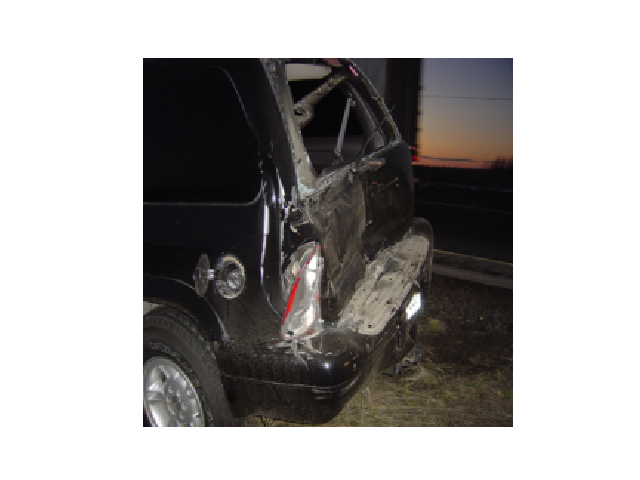

Bounding box corners tensor([[  0,   0, 250, 197]])


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, bbox_labels, scale = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [4]:
tensor_im = x.to(device).unsqueeze(0)

In [5]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101

n_fg_class = 20
feat_stride = 520//16
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [6]:
out = rfcn(tensor_im)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


In [7]:
from __future__ import  absolute_import
from trainer import FasterRCNNTrainer
trainer = FasterRCNNTrainer(rfcn).to(device)

In [ ]:
train_loader = td.DataLoader(train_set, batch_size=1, pin_memory = True, shuffle = True)
val_loader  = td.DataLoader(val_set, batch_size=1, pin_memory = True, shuffle = False)

In [ ]:

import time
t = time.time()
img, bboxes, lbls, scale = next(iter(train_loader))
img = img.to(device)
bboxes = bboxes.to(device)
lbls = lbls.to(device)
scale = scale.item()
loss =trainer.train_step(img, bboxes, lbls, scale)
elapsed = time.time() - t
print("Elapsed time: ", elapsed)
print("Loss tuple: ", loss)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


LossTuple(rpn_loc_loss=tensor(5.0048, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(4.8224, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(2.2565, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>))
tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>
Elapsed time:  2.562675714492798
Loss tuple:  LossTuple(rpn_loc_loss=tensor(5.0048, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(4.8224, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(2.2565, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>))


In [4]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import matplotlib
from tqdm import tqdm


from utils.config import opt
from model.rfcn_resnet101 import RFCNResnet101
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

matplotlib.use('agg')


def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result


def train(train_set,val_set, load_path = False, epochs = 1, lr=1e-3, plot_every = 40, lr_decay = 1e-3,test_num=500):

    train_dataloader = td.DataLoader(train_set, batch_size = 1, pin_memory = False, shuffle = True)
    test_dataloader = td.DataLoader(val_set, batch_size = 1, pin_memory = True)
    faster_rcnn = RFCNResnet101().cuda()
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    if load_path:
        trainer.load(load_path)
        print('load pretrained model from %s' % load_path)
#     trainer.vis.text(dataset.db.label_names, win='labels')
    best_map = 0
    lr_ = lr
    for epoch in range(epochs):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(train_dataloader)):
            scale = at.scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            losses = trainer.train_step(img, bbox, label, scale)
            loss_info = 'Iter {}; Losses: RPN loc {}, RPN cls: {}, ROI loc {}, ROI cls {}, Total:{}'.format(
                                                str(ii),
                                                str(losses[0].cpu().data.numpy()),
                                                str(losses[1].cpu().data.numpy()),
                                                str(losses[2].cpu().data.numpy()),
                                                str(losses[3].cpu().data.numpy()),                                
                                                str(losses[4].cpu().data.numpy()))
            print(loss_info)
#             if (ii + 1) % plot_every == 0:


#                 # plot loss
#                 trainer.vis.plot_many(trainer.get_meter_data())

#                 # plot groud truth bboxes
#                 ori_img_ = inverse_normalize(at.tonumpy(img[0]))
#                 gt_img = visdom_bbox(ori_img_,
#                                      at.tonumpy(bbox_[0]),
#                                      at.tonumpy(label_[0]))
#                 trainer.vis.img('gt_img', gt_img)

#                 # plot predicti bboxes
#                 _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
#                 pred_img = visdom_bbox(ori_img_,
#                                        at.tonumpy(_bboxes[0]),
#                                        at.tonumpy(_labels[0]).reshape(-1),
#                                        at.tonumpy(_scores[0]))
#                 trainer.vis.img('pred_img', pred_img)

#                 # rpn confusion matrix(meter)
#                 trainer.vis.text(str(trainer.rpn_cm.value().tolist()), win='rpn_cm')
#                 # roi confusion matrix
#                 trainer.vis.img('roi_cm', at.totensor(trainer.roi_cm.conf, False).float())
#         eval_result = eval(test_dataloader, faster_rcnn, test_num=test_num)
#         trainer.vis.plot('test_map', eval_result['map'])
#         lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
#         log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_),
#                                                   str(eval_result['map']),
#                                                   str(trainer.get_meter_data()))
#         print(log_info)

#         if eval_result['map'] > best_map:
#             best_map = eval_result['map']
#             best_path = trainer.save(best_map=best_map)
#         if epoch == 9:
#             trainer.load(best_path)
#             trainer.faster_rcnn.scale_lr(lr_decay)
#             lr_ = lr_ * lr_decay

#         if epoch == 13: 
#             break



In [ ]:

train(train_set,val_set, load_path = False, epochs = 1, lr=1e-3, plot_every =40)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)
0it [00:00, ?it/s]

model construct completed


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


LossTuple(rpn_loc_loss=tensor(2.3801, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(1.4165, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(2.3439, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0560, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(9.1964, device='cuda:0', grad_fn=<AddBackward0>))
tensor(9.1964, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


1it [00:03,  3.67s/it]

Iter 0; Losses: RPN loc 2.380054, RPN cls: 1.4165028, ROI loc 2.3438513, ROI cls 3.0559566, Total:9.196365
LossTuple(rpn_loc_loss=tensor(6.4707, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(10.0399, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(47.7562, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0649, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(67.3317, device='cuda:0', grad_fn=<AddBackward0>))
tensor(67.3317, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


2it [00:07,  3.69s/it]

Iter 1; Losses: RPN loc 6.4706597, RPN cls: 10.039937, ROI loc 47.7562, ROI cls 3.0648618, Total:67.331665


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:68: RuntimeWarning: overflow encountered in multiply
  h = xp.exp(dh) * src_height[:, xp.newaxis]
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:69: RuntimeWarning: overflow encountered in multiply
  w = xp.exp(dw) * src_width[:, xp.newaxis]


LossTuple(rpn_loc_loss=tensor(73.2931, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(176.5188, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(7.3999, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0751, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(260.2868, device='cuda:0', grad_fn=<AddBackward0>))
tensor(260.2868, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


3it [00:09,  3.32s/it]

Iter 2; Losses: RPN loc 73.29308, RPN cls: 176.51875, ROI loc 7.3999343, ROI cls 3.075062, Total:260.28683
LossTuple(rpn_loc_loss=tensor(53.2945, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(48.5098, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(116.3589, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0159, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(221.1790, device='cuda:0', grad_fn=<AddBackward0>))
tensor(221.1790, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


4it [00:13,  3.35s/it]

Iter 3; Losses: RPN loc 53.294506, RPN cls: 48.509773, ROI loc 116.35888, ROI cls 3.0159037, Total:221.17905
LossTuple(rpn_loc_loss=tensor(43.4892, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.3609, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(149.1578, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0732, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(203.0811, device='cuda:0', grad_fn=<AddBackward0>))
tensor(203.0811, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


5it [00:15,  2.98s/it]

Iter 4; Losses: RPN loc 43.489193, RPN cls: 7.360905, ROI loc 149.15779, ROI cls 3.0732272, Total:203.08112
LossTuple(rpn_loc_loss=tensor(30.9626, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(20.2857, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(84.0688, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.9702, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(138.2873, device='cuda:0', grad_fn=<AddBackward0>))
tensor(138.2873, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


6it [00:19,  3.18s/it]

Iter 5; Losses: RPN loc 30.962612, RPN cls: 20.285746, ROI loc 84.06876, ROI cls 2.9702048, Total:138.28732
LossTuple(rpn_loc_loss=tensor(8.9698, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.9609, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(115.8499, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.5978, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(135.3784, device='cuda:0', grad_fn=<AddBackward0>))
tensor(135.3784, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


7it [00:25,  4.16s/it]

Iter 6; Losses: RPN loc 8.969848, RPN cls: 7.9609003, ROI loc 115.84991, ROI cls 2.5977643, Total:135.37842
LossTuple(rpn_loc_loss=tensor(16.7232, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(15.4029, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(170.9347, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.4713, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(205.5321, device='cuda:0', grad_fn=<AddBackward0>))
tensor(205.5321, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


8it [00:30,  4.38s/it]

Iter 7; Losses: RPN loc 16.72325, RPN cls: 15.402873, ROI loc 170.9347, ROI cls 2.4713166, Total:205.53214
LossTuple(rpn_loc_loss=tensor(6.9701, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.0849, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(163.4146, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2948, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(179.7645, device='cuda:0', grad_fn=<AddBackward0>))
tensor(179.7645, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


9it [00:36,  4.75s/it]

Iter 8; Losses: RPN loc 6.9701414, RPN cls: 7.084911, ROI loc 163.41463, ROI cls 2.2948308, Total:179.76451
LossTuple(rpn_loc_loss=tensor(5.7185, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(11.8678, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(59.3832, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2028, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(79.1723, device='cuda:0', grad_fn=<AddBackward0>))
tensor(79.1723, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


10it [00:38,  4.13s/it]

Iter 9; Losses: RPN loc 5.7185235, RPN cls: 11.8677635, ROI loc 59.38317, ROI cls 2.20284, Total:79.1723
LossTuple(rpn_loc_loss=tensor(63.9456, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(79.5933, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(61.2033, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(207.0977, device='cuda:0', grad_fn=<AddBackward0>))
tensor(207.0977, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


11it [00:41,  3.65s/it]

Iter 10; Losses: RPN loc 63.9456, RPN cls: 79.59328, ROI loc 61.203342, ROI cls 2.3554447, Total:207.09766
LossTuple(rpn_loc_loss=tensor(1.6128, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(3.1386, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(79.0471, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2635, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(86.0619, device='cuda:0', grad_fn=<AddBackward0>))
tensor(86.0619, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


12it [00:50,  5.37s/it]

Iter 11; Losses: RPN loc 1.612764, RPN cls: 3.1386008, ROI loc 79.047066, ROI cls 2.2634706, Total:86.061905
LossTuple(rpn_loc_loss=tensor(17.7015, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(24.1320, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(74.7092, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.1915, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(118.7342, device='cuda:0', grad_fn=<AddBackward0>))
tensor(118.7342, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


13it [00:59,  6.47s/it]

Iter 12; Losses: RPN loc 17.701508, RPN cls: 24.132027, ROI loc 74.70923, ROI cls 2.1914713, Total:118.73424
LossTuple(rpn_loc_loss=tensor(0.7495, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(18.9906, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(34.3717, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(56.2656, device='cuda:0', grad_fn=<AddBackward0>))
tensor(56.2656, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


14it [01:06,  6.54s/it]

Iter 13; Losses: RPN loc 0.7494711, RPN cls: 18.990593, ROI loc 34.37168, ROI cls 2.1538696, Total:56.265617
LossTuple(rpn_loc_loss=tensor(4.5124, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.1657, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(110.0921, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2162, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(123.9864, device='cuda:0', grad_fn=<AddBackward0>))
tensor(123.9864, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


15it [01:14,  6.91s/it]

Iter 14; Losses: RPN loc 4.5123944, RPN cls: 7.1657367, ROI loc 110.09207, ROI cls 2.2161932, Total:123.9864
LossTuple(rpn_loc_loss=tensor(7.3091, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(3.9843, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(181.0607, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2770, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(194.6312, device='cuda:0', grad_fn=<AddBackward0>))
tensor(194.6312, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


16it [01:21,  7.09s/it]

Iter 15; Losses: RPN loc 7.3091497, RPN cls: 3.984284, ROI loc 181.06071, ROI cls 2.2770157, Total:194.63116
LossTuple(rpn_loc_loss=tensor(1.6200, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(22.3096, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(27.2546, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.1470, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(53.3312, device='cuda:0', grad_fn=<AddBackward0>))
tensor(53.3312, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


17it [01:29,  7.34s/it]

Iter 16; Losses: RPN loc 1.6199678, RPN cls: 22.309637, ROI loc 27.254604, ROI cls 2.146979, Total:53.331192
LossTuple(rpn_loc_loss=tensor(6.1768, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(4.8710, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(56.4018, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2117, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(69.6613, device='cuda:0', grad_fn=<AddBackward0>))
tensor(69.6613, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


18it [02:02, 15.05s/it]

Iter 17; Losses: RPN loc 6.1768284, RPN cls: 4.8710217, ROI loc 56.40183, ROI cls 2.2116647, Total:69.66134
LossTuple(rpn_loc_loss=tensor(0.0486, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(0.7675, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(13.4365, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.1545, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(16.4071, device='cuda:0', grad_fn=<AddBackward0>))
tensor(16.4071, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


19it [02:44, 23.04s/it]

Iter 18; Losses: RPN loc 0.048587427, RPN cls: 0.76751554, ROI loc 13.436472, ROI cls 2.1545115, Total:16.407085
LossTuple(rpn_loc_loss=tensor(0.4429, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(0.9347, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(49.5970, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2169, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(53.1915, device='cuda:0', grad_fn=<AddBackward0>))
tensor(53.1915, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


20it [03:26, 28.87s/it]

Iter 19; Losses: RPN loc 0.4428545, RPN cls: 0.9346992, ROI loc 49.59703, ROI cls 2.2169192, Total:53.1915
LossTuple(rpn_loc_loss=tensor(0.9385, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(81.9396, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.2794, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(85.5881, device='cuda:0', grad_fn=<AddBackward0>))
tensor(85.5881, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


31.951778411865234